## Assignment 1: Registration of fluorescein angiography retinal images
  Filiz İpek Oktay 


In [1]:
# Download the sample images
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1gTsX8yMtbi4Dq8oHJpqg9VQ3hcB4di5A -O reference_image_1.jpg

!wget --no-check-certificate \
    https://drive.google.com/uc?id=19WE6K3ljoJT8phAWk7wP09mYJ5bJ98gm -O test_image_1.jpg

!wget --no-check-certificate \
    https://drive.google.com/uc?id=1UAGF1bFaBRdpwwCWNc373lJwVINff7MT -O reference_image_2.tif

!wget --no-check-certificate \
    https://drive.google.com/uc?id=1pVa-8Nwr0n4BMYMI6-XXemxjh5E0HHlG -O test_image_2.tif

--2024-10-14 09:13:31--  https://drive.google.com/uc?id=1gTsX8yMtbi4Dq8oHJpqg9VQ3hcB4di5A
Resolving drive.google.com (drive.google.com)... 74.125.201.139, 74.125.201.138, 74.125.201.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.201.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1gTsX8yMtbi4Dq8oHJpqg9VQ3hcB4di5A [following]
--2024-10-14 09:13:31--  https://drive.usercontent.google.com/download?id=1gTsX8yMtbi4Dq8oHJpqg9VQ3hcB4di5A
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.214.132, 2607:f8b0:4001:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.214.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2623657 (2.5M) [image/jpeg]
Saving to: ‘reference_image_1.jpg’

reference_image_1.j 100%[===================>]   2.50M  --.-KB/s    in 0.02s   

2024-10-14 09:13:33 (107 MB/s) - ‘re

In [2]:
# importing necessary packages
import cv2
import numpy as np
%matplotlib inline
from numpy.linalg import lstsq
from matplotlib import pyplot as plt

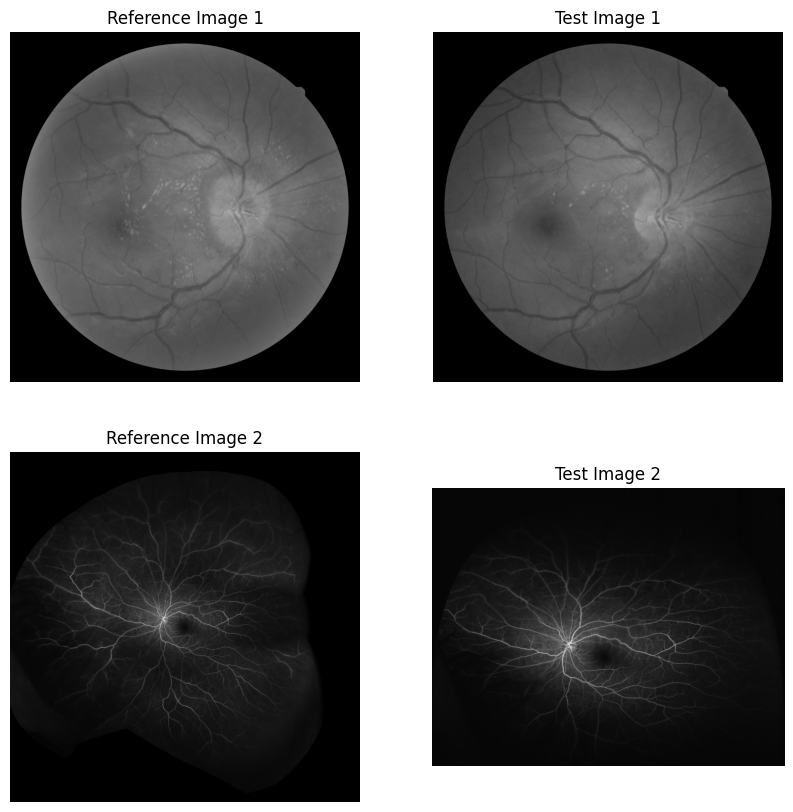

In [3]:
# load and display images
reference_image_1 = cv2.imread('reference_image_1.jpg', cv2.IMREAD_GRAYSCALE)
reference_image_2 = cv2.imread('reference_image_2.tif', cv2.IMREAD_GRAYSCALE)

test_image_1 = cv2.imread('test_image_1.jpg', cv2.IMREAD_GRAYSCALE)
test_image_2 = cv2.imread('test_image_2.tif', cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(reference_image_1, cmap='gray')
axs[0, 0].set_title("Reference Image 1")
axs[0, 1].imshow(test_image_1, cmap='gray')
axs[0, 1].set_title("Test Image 1")
axs[1, 0].imshow(reference_image_2, cmap='gray')
axs[1, 0].set_title("Reference Image 2")
axs[1, 1].imshow(test_image_2, cmap='gray')
axs[1, 1].set_title("Test Image 2")

for ax in axs.flat:
    ax.axis('off')

In [4]:
# reference_img_x, reference_img_y, test_img_x, test_img_y
CONTROL_POINTS_1 = [
  [332.000, 872.000, 388.000, 822.000],
  [370.000, 1897.000, 357.000, 1849.000],
  [1212.000, 2483.000, 1153.000, 2487.000],
  [1761.000, 348.000, 1843.000, 400.000],
  [2384.000, 1912.000, 2358.000, 2000.000],
  [2527.000, 1099.000, 2556.000, 1198.000],
  [1922.000, 1131.000, 1949.000, 1194.000],
  [642.000, 1222.000, 670.000, 1192.000],
  [1930.000, 1408.000, 1944.000, 1460.000],
  [1339.000, 1768.000, 1328.000, 1784.000]
]


CONTROL_POINTS_2 = [
  [1276.7,1697.5,793.81,1439.19],
  [1725.5,1314.3,1397.56,926.19],
  [1965.98,1195.38,1811.19,763.81],
  [2600.29,1390.69,2884.81,1087.44],
  [2447.66,1640.86,2624.19,1375.81],
  [1836.78,1760.34,1638.69,1492.81],
  [1464.01,1530.99,1022.56,1223.56],
  [1286.35,2101.64,827.19,1913.94],
  [1844.89,2130.84,1656.69,1999.81],
  [2344.07,1997.9,2468.56,1837.06],
  [2215.9,2228.81,2276.94,2155.06],
  [1840.87,2564.24,1625.94,2602.06],
  [2577.49,2438.16,2894.19,2383.06],
  [1414.47,1047.6,766.44,711.69]
]

# Task 1: #
* Padding the images to the larger images to have the same sized images
* Calculating the affine transform (registration) matrix between each pair of images using the least squares method

In [5]:
# Function to pad the smaller image to match the size of the larger one
def pad_to_larger_image(reference_image: np.ndarray, test_image: np.ndarray) -> (np.ndarray, np.ndarray):
    # Get dimensions of both images
    height_ref, width_ref = reference_image.shape[:2]
    height_test, width_test = test_image.shape[:2]

    # Target size is the maximum dimensions between the reference and test images
    target_height = max(height_ref, height_test)
    target_width = max(width_ref, width_test)

    # Padding for reference image (only if it's smaller)
    pad_height_ref_top = (target_height - height_ref) // 2
    pad_height_ref_bottom = target_height - height_ref - pad_height_ref_top
    pad_width_ref_left = (target_width - width_ref) // 2
    pad_width_ref_right = target_width - width_ref - pad_width_ref_left

    padded_reference_image = np.pad(reference_image,
                                    ((pad_height_ref_top, pad_height_ref_bottom),
                                     (pad_width_ref_left, pad_width_ref_right)),
                                    mode='constant', constant_values=0)

    # Padding for test image (only if it's smaller)
    pad_height_test_top = (target_height - height_test) // 2
    pad_height_test_bottom = target_height - height_test - pad_height_test_top
    pad_width_test_left = (target_width - width_test) // 2
    pad_width_test_right = target_width - width_test - pad_width_test_left

    padded_test_image = np.pad(test_image,
                               ((pad_height_test_top, pad_height_test_bottom),
                                (pad_width_test_left, pad_width_test_right)),
                               mode='constant', constant_values=0)

    return padded_reference_image, padded_test_image


# Pad images to match the larger one
reference_image_1, test_image_1 = pad_to_larger_image(reference_image_1, test_image_1)

# Pad the second set of images to match the larger one
reference_image_2, test_image_2 = pad_to_larger_image(reference_image_2, test_image_2)

# Check the final shapes of the images
print(f"Image 1 shapes: Padded Reference ({reference_image_1.shape}), Test ({test_image_1.shape})")
print(f"Image 2 shapes: Padded Reference ({reference_image_2.shape}), Test ({test_image_2.shape})")


Image 1 shapes: Padded Reference ((2912, 2912)), Test ((2912, 2912))
Image 2 shapes: Padded Reference ((4000, 4000)), Test ((4000, 4000))


In [6]:
def affTransMat(control_points: np.ndarray) -> np.ndarray:

    # Prepare empty matrices for A and B
    arrA = []
    arrB = []

    # Populate arrA and arrB based on control points
    for x_ref, y_ref, x_prime, y_prime in control_points:
        # Add rows for x' and y' equations to arrA
        arrA.append([x_prime, y_prime, 1, 0, 0, 0])  # x' equation
        arrA.append([0, 0, 0, x_prime, y_prime, 1])  # y' equation

        # Corresponding x_prime and y_prime in arrB
        arrB.append(x_ref)
        arrB.append(y_ref)

    # Convert arrA and arrB into NumPy arrays
    arrA = np.array(arrA)
    arrB = np.array(arrB)

    # Solve for transformation matrix using least squares
    T_matrix = np.linalg.inv(arrA.T @ arrA) @ arrA.T @ arrB

    return T_matrix.reshape(2,3)

In [7]:
print('Affine Transformation of the First Image Set')
print(affTransMat(CONTROL_POINTS_1))


Affine Transformation of the First Image Set
[[ 1.00058275e+00  6.75474685e-02 -1.10721458e+02]
 [-6.83793365e-02  9.99605425e-01  7.54322178e+01]]


In [8]:
print('Affine Transformation of the Second Image Set')
print(affTransMat(CONTROL_POINTS_2))

Affine Transformation of the Second Image Set
[[ 6.11271705e-01 -3.67788409e-02  8.96807057e+02]
 [-1.94208138e-03  7.82356361e-01  5.67471715e+02]]


# Task 2#

*   Appliying the matrix to perform registration and displaying the results



In [9]:
def registered_image(reference_image: np.ndarray, test_image: np.ndarray, controlPoints: np.ndarray) ->np.ndarray:
  T_matrix = affTransMat(controlPoints)
  T_matrix = T_matrix[:2, :]

  # Apply the affine transformation
  registered_image = cv2.warpAffine(reference_image, T_matrix, (test_image.shape[1], test_image.shape[0]), flags= cv2.INTER_CUBIC)
  return registered_image

def displayRes(reference_image: np.ndarray, test_image: np.ndarray, registered_image: np.ndarray):

  # Display the results
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plt.imshow(reference_image, cmap='gray')
  plt.title('Reference Image')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(registered_image, cmap='gray')
  plt.title('Registered Image')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(test_image, cmap='gray')
  plt.title('Test Image')
  plt.axis('off')

  plt.show()



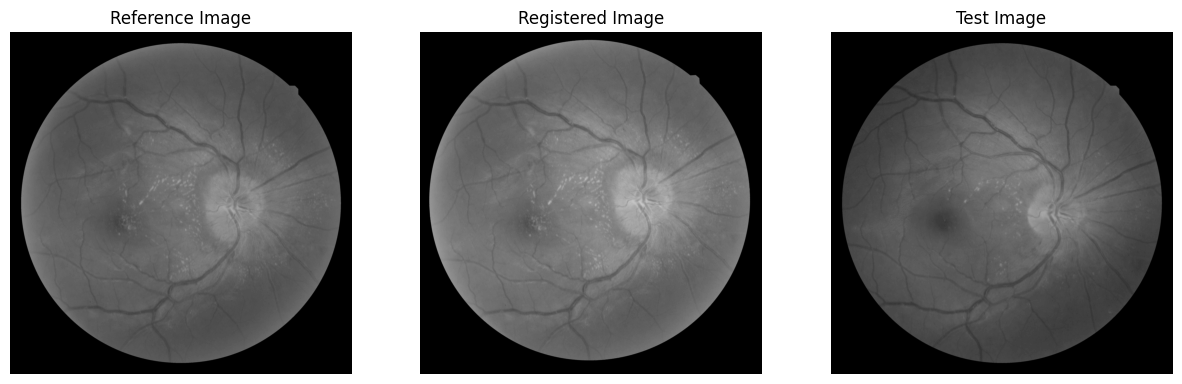

(None,)

In [10]:
#Applying the Transformation to the Reference Image and Displaying the Results
registered_image_1 = registered_image(reference_image_1, test_image_1, CONTROL_POINTS_1)
displayRes(reference_image_1, test_image_1, registered_image_1),

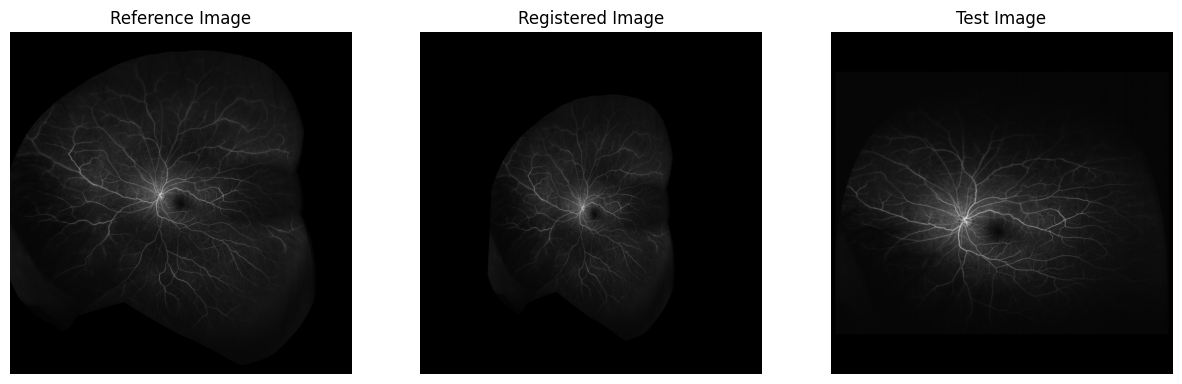

In [11]:
#Applying the Transformation to the Reference Image 2 and Displaying the Results
registered_image_2 = registered_image(reference_image_2, test_image_2, CONTROL_POINTS_2)
displayRes(reference_image_2, test_image_2, registered_image_2)

# Task 3#

* Transforming the registered image into recovered one, by applying the inverse transformation matrix to the registered image
* Calculating the MSE(Mean Squared Error) in order to measure how the transformation method is working


In [12]:
def recovered_image(controlPoints: np.ndarray, reference_image: np.ndarray, registered_image: np.ndarray) -> np.ndarray:
    T_matrix_copy = affTransMat(controlPoints)
    T_inv = np.linalg.inv(np.vstack([T_matrix_copy, [0, 0, 1]]))[:2, :]
    T_inv = T_inv[:2]

    recovered_image_result = cv2.warpAffine(registered_image, T_inv, (reference_image.shape[1], reference_image.shape[0]))

    plt.figure(figsize=(10, 5))

    # Display the recovered image
    plt.subplot(1, 2, 1)
    plt.imshow(recovered_image_result, cmap='gray')
    plt.title('Recovered Image')
    plt.axis('off')

    # Display the difference between the reference and recovered images
    plt.subplot(1, 2, 2)
    difference_image = cv2.subtract(recovered_image_result, reference_image)
    plt.imshow(difference_image, cmap='gray')
    plt.title('Difference Between Reference Image \n and Recovered Image')
    plt.axis('off')


    return recovered_image_result

In [13]:
def mse(imageA: np.ndarray, imageB: np.ndarray) -> float:
    # Check if the images have the same dimensions
    if imageA.shape != imageB.shape:
        raise ValueError("Input images must have the same dimensions.")

    # Initialize the error sum
    err_sum = 0.0
    height, width = imageA.shape[:2]

    # Iterate through each pixel in the images
    for i in range(height):
        for j in range(width):
            # Convert pixel values to float to prevent overflow
            pixel_diff = float(imageA[i, j]) - float(imageB[i, j])
            # Calculate the squared difference for each pixel
            err_sum += pixel_diff ** 2

    # Calculate the mean squared error
    mse_value = err_sum / (height * width)  # Total number of pixels

    return mse_value


MSE between reference image 1 and recovered image 1: 1.1469738944949281


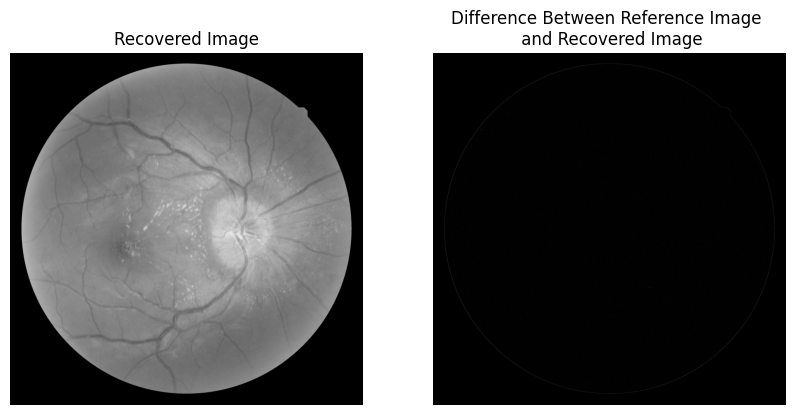

In [14]:
recovered_image_1 = recovered_image(CONTROL_POINTS_1, reference_image_1, registered_image_1)
mse_value_1 = mse(reference_image_1, recovered_image_1)
print("MSE between reference image 1 and recovered image 1:", mse_value_1)


MSE between reference image 2 and recovered image 2: 1.2750050625


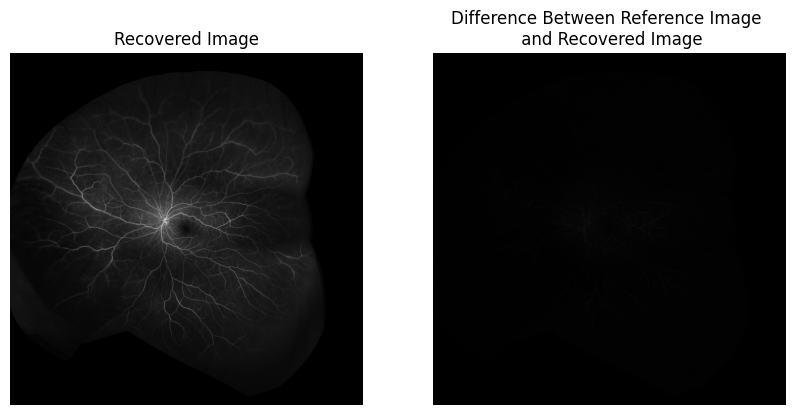

In [15]:
recovered_image_2 = recovered_image(CONTROL_POINTS_2, reference_image_2, registered_image_2)
mse_value_2 = mse(reference_image_2, recovered_image_2)
print("MSE between reference image 2 and recovered image 2:", mse_value_2)